Dataset : [MMOTU](https://www.kaggle.com/datasets/orvile/mmotu-ovarian-ultrasound-images-dataset/code)

# 0. Import

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import torch
from torchvision import transforms
import random

import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Loading

In [ ]:
FILE_PATH = '/content/drive/My Drive/졸업프로젝트/TestDataset/MMOTU'

In [ ]:
data_dir = Path(FILE_PATH)

if not data_dir.is_dir():
    print(f"[ERROR]: '{FILE_PATH}'를 찾을 수 없음")
else:
    print("Scanning all items from ", {FILE_PATH})
    # 전체 file list 가져오기
    all_recursive_items = list(tqdm(data_dir.rglob('*'), desc="Recursive Scan Progress", unit="item"))

    image_files = []
    txt_files = []

    sub_dir_counts = defaultdict(lambda: defaultdict(int))

    main_subfolders = ['OTU_2d', 'OTU_3d']

    for item in all_recursive_items:
        if item.is_file():
            suffix = item.suffix.lower()
            if suffix == '.png':
                image_files.append(item)
            elif suffix == '.txt':
                txt_files.append(item)

            # 데이터셋 구조 파악
            try:
                relative_parts = item.parts[len(data_dir.parts):]

                if len(relative_parts) >= 2:
                    major_folder = relative_parts[0]
                    class_folder = relative_parts[1]

                    if major_folder in main_subfolders:
                        sub_dir_counts[major_folder][class_folder] += 1

            except IndexError:
                pass

    print("\n[Directory Sumamry]")
    for major_folder in main_subfolders:
        if major_folder in sub_dir_counts:
            print(f"📂 {major_folder}/")
            total_in_major = sum(sub_dir_counts[major_folder].values())

            for class_folder, count in sub_dir_counts[major_folder].items():
                print(f"  └── 📁 {class_folder}/ (Contains {count} items)")

            print(f"  (Total items in {major_folder}: {total_in_major} files)")
        else:
            print(f"[WARN] {major_folder}/ not found or empty.")

    print('\n[Dataset Summary]')
    print(f"   File Path: {FILE_PATH}")
    print(f"   PNG Image Files Count: {len(image_files)}")
    print(f"   TXT Label Files Count: {len(txt_files)}")


    print('\n[PNG Image File Samples (Top 3)]')
    for f in image_files[:3]:
        print(f"- {f.name}")

    print('\n[TXT File Samples (Top 3)]')
    for f in txt_files[:3]:
        print(f"- {f.name}")

Scanning all items from  {'/content/drive/My Drive/졸업프로젝트/TestDataset/MMOTU'}


Recursive Scan Progress: 9521item [00:14, 644.77item/s]



[Directory Sumamry]
📂 OTU_2d/
  └── 📁 train.txt/ (Contains 1 items)
  └── 📁 train_cls.txt/ (Contains 1 items)
  └── 📁 val.txt/ (Contains 1 items)
  └── 📁 val_cls.txt/ (Contains 1 items)
  └── 📁 images/ (Contains 1469 items)
  └── 📁 annotations/ (Contains 4407 items)
  (Total items in OTU_2d: 5880 files)
📂 OTU_3d/
  └── 📁 train.txt/ (Contains 1 items)
  └── 📁 train_cls.txt/ (Contains 1 items)
  └── 📁 val.txt/ (Contains 1 items)
  └── 📁 trainval.txt/ (Contains 1 items)
  └── 📁 val_cls.txt/ (Contains 1 items)
  └── 📁 annotations/ (Contains 510 items)
  └── 📁 images/ (Contains 170 items)
  (Total items in OTU_3d: 685 files)

[Dataset Summary]
   File Path: /content/drive/My Drive/졸업프로젝트/TestDataset/MMOTU
   PNG Image Files Count: 6386
   TXT Label Files Count: 1478

[PNG Image File Samples (Top 3)]
- 100_binary_binary.PNG
- 100.PNG
- 100_binary.PNG

[TXT File Samples (Top 3)]
- train.txt
- train_cls.txt
- val.txt


In [ ]:
# 다음 단계를 위하여 전역 변수로 저장
global IMAGE_FILES
global LABEL_FILES
IMAGE_FILES = image_files
TXT_FILES = txt_files

# 2. Data Preprocessing


## for ResNet50 and ViT

In [ ]:
TARGET_FOLDER = 'OTU_2d'
IMAGE_FOLDER = 'images'
ANNOTATION_FOLDER = 'annotations'
TRAIN_CLS_FILE_NAME = 'train_cls.txt'
VAL_CLS_FILE_NAME = 'val_cls.txt'

In [ ]:
AUG_FACTOR = 24 # 악성 sample 증강 횟수

In [ ]:
# ResNet50
TARGET_SIZE = 224
# PyTorch Pre-trained Model의 ImageNet 표준 정규화 값
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [ ]:
BINARY_MAPPING = {
    0: 0, # Chocolate cyst (Benign)
    1: 0, # Serous cystadenoma (Benign)
    2: 0, # Teratoma (Benign)
    3: 0, # Theca cell tumor (Benign)
    4: 0, # Simple cyst (Benign)
    5: 0, # Normal ovary (Benign)
    6: 0, # Mucinous cystadenoma (Benign/Borderline)
    7: 1  # High grade serous cystadenocarcinoma (Malignant)
}

In [ ]:
def resize_and_pad(img, target_size, fill_value=0):
    """
    image 비율을 유지하며 resizing하고,
    padding해서 target_size에 맞춤
    """
    original_width, original_height = img.size
    target_width, target_height = target_size
    ratio = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    new_img = Image.new(img.mode, target_size, fill_value)

    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    new_img.paste(resized_img, (x_offset, y_offset))
    return new_img

In [ ]:
normalize_transform = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

In [ ]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2), # 상하 반전은 20% 확률로 낮춤
    transforms.RandomRotation(degrees=5, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])
# RandomHorizontalFlip: 50% 확률로 좌우 반전
# RandomVerticalFlip: 50% 확률로 상하 반전 (초음파에서는 주의하 사용)
# RandomRotation: [-10, 10]도 사이에서 회전
# ColorJitter: 대비, 밝기 변화 (의료 영상에서는 제한적으로 사용)

In [ ]:
def load_hierarchical_labels(cls_file_path):
    """
    train_cls.txt 에 있는 label을 loading 하여,
    binary label과 original label을 dictionary로 반환
    { 'stem': {'binary': 0/1, 'original': 0-7} }
    """
    try:
        # txt 파일 읽어서 DataFrame으로 변환
        # 파일은 공백으로 구분되어 있음
        df_labels = pd.read_csv(cls_file_path, sep=r'\s+', header=None, names=['filename', 'label'])

        # 원본 label 저장
        df_labels['original_label'] = df_labels['label']

        # 원본 label을 binary label로 매핑
        df_labels['binary_label'] = df_labels['label'].map(BINARY_MAPPING)

        if df_labels['binary_label'].isnull().any():
            print("[ERROR]: Undefined label index found in the classification file!")
            return {}

        # dictionary의 Key를 filename의 stem으로 통일
        # ex. 658.JPG -> 658
        df_labels['stem'] = df_labels['filename'].apply(lambda x: Path(x).stem.lower())

        # label dictionary 생성
        # K : stem, V : label
        label_dict = df_labels.set_index('stem')[['binary_label', 'original_label']].T.to_dict()

        print(f"Loaded {len(label_dict)} classification labels from {cls_file_path.name}")
        return label_dict
    except Exception as e:
        print(f"[ERROR] loading classification labels: {e}")
        return {}

In [ ]:
OUTPUT_PATH = Path(FILE_PATH) / "ResNet50_ViT_Processed_Data"

In [ ]:
def create_split_dataset(output_path):
    """
    train/validation set 생성
    """

    data_dir = Path(FILE_PATH) / TARGET_FOLDER
    image_folder = data_dir / IMAGE_FOLDER

    # train, validation label load
    train_labels = load_labels(data_dir / TRAIN_CLS_FILE_NAME)
    val_labels = load_labels(data_dir / VAL_CLS_FILE_NAME)

    if not train_labels and not val_labels:
        print("[ERROR] Failed to load both Train and Validation labels.")
        return None, None, None, None

    image_files = {f.stem.lower(): f for f in image_folder.iterdir() if f.is_file()}
    if not image_files:
        print(f"[ERROR] No image files found in {image_folder}")
        return None, None

    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []

    def apply_base_transforms(pil_img):
        img_padded = resize_and_pad(pil_img, (TARGET_SIZE, TARGET_SIZE), fill_value=0)
        img_np = np.array(img_padded, dtype=np.float32) / 255.0
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
        return normalize_transform(img_tensor).numpy()

    # train set preprocessing loop
    train_keys = list(train_labels.keys())
    for img_id in tqdm(train_keys, desc=f"Processing Train and Validation Sets", unit="image"):

        if img_id not in image_files:
            continue

        img_file = image_files[img_id]
        label = train_labels[img_id]

        try:
            img = Image.open(img_file).convert('RGB')

            # 1. 원본 sample 추가 (augmentation 미적용)
            X_train_list.append(apply_base_transforms(img))
            y_train_list.append(label)

            # 2. 악성 클래스에만 augmentation 적용
            if label == 1: # 악성인 경우
                for _ in range(AUG_FACTOR):
                    img_augmented_pil = augmentation_transforms(img)
                    X_train_list.append(apply_base_transforms(img_augmented_pil))
                    y_train_list.append(label)

        except Exception as e:
            print(f"[WARN] Failed to process train image {img_file.name}. Error: {e}")
            continue

    # validation set preprocessing loop
    val_keys = list(val_labels.keys())
    for img_id in tqdm(val_keys, desc="Processing Validation Set (No Augmentation)", unit="image"):

        if img_id not in image_files:
            continue

        img_file = image_files[img_id]
        label = val_labels[img_id]

        try:
            img = Image.open(img_file).convert('RGB')

            img_padded = resize_and_pad(img, (TARGET_SIZE, TARGET_SIZE), fill_value=0)
            img_np = np.array(img_padded, dtype=np.float32) / 255.0

            img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
            img_final_np = normalize_transform(img_tensor).numpy()

            X_val_list.append(img_final_np)
            y_val_list.append(label)

        except Exception as e:
            print(f"[WARN] Failed to process validation image {img_file.name}. Error: {e}")
            continue

    # 최종 numPy 배열로 변환
    # (C, H, W) 형태 유지
    X_train_np = np.array(X_train_list)
    y_train_np = np.array(y_train_list, dtype=int)
    X_val_np = np.array(X_val_list)
    y_val_np = np.array(y_val_list, dtype=int)

    # preprocessing 완료된 dataset 저장
    if not output_path.exists():
        output_path.mkdir(parents=True, exist_ok=True)

    # Train 저장
    train_save_path = output_path / "train_augmented2_data.npz"
    np.savez_compressed(train_save_path, images=X_train_np, labels=y_train_np)
    print(f"\nTrain Set saved: {train_save_path.resolve()} (Samples: {len(X_train_np)})")

    # Validation 저장
    val_save_path = output_path / "validation_data.npz"
    np.savez_compressed(val_save_path, images=X_val_np, labels=y_val_np)
    print(f"Validation Set saved: {val_save_path.resolve()} (Samples: {len(X_val_np)})")

    return X_train_np, y_train_np, X_val_np, y_val_np

In [ ]:
def visualize_samples(X, Y, split_name, num_samples=5):
    """ 전처리된 image sample을 확인하고 시각화 """
    # pyTorch Tensor (C, H, W)를 Matplotlib이 선호하는 (H, W, C)로 변환
    # Tensor를 numPy로 변환하고 채널을 마지막 축으로 이동 (transpose)
    # normalization을 역변환하여 시각화 가능한 0-1 범위로 되돌리기

    def denormalize_image(tensor_np):
        # (C, H, W) -> (H, W, C)
        img = tensor_np.transpose((1, 2, 0))

        # normalization 역변환
        mean = np.array(IMAGENET_MEAN)
        std = np.array(IMAGENET_STD)
        img = img * std + mean

        # 픽셀 값이 0-1 범위 밖에 있을 수 있으므로 clipping
        img = np.clip(img, 0, 1)
        return img


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))

    # random sample index 선택 (augmentation된 데이터도 잘 섞여 있는지 확인)
    indices = random.sample(range(len(X)), min(num_samples, len(X)))

    for i in range(num_samples):
        if i >= len(X):
            break

        img_denorm = denormalize_image(X[i])
        label = Y[i]

        axes[i].imshow(img_denorm)
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle(f"{split_name} Set Samples (Denormalized for Viewing)", fontsize=16)
    plt.tight_layout()
    plt.show()

Loaded 1000 classification labels from train_cls.txt
Loaded 469 classification labels from val_cls.txt


Processing Validation Set (No Augmentation): 100%|██████████| 469/469 [00:08<00:00, 52.64image/s]



Train Set saved: /content/drive/My Drive/졸업프로젝트/TestDataset/MMOTU/ResNet50_ViT_Processed_Data/train_augmented2_data.npz (Samples: 1912)
Validation Set saved: /content/drive/My Drive/졸업프로젝트/TestDataset/MMOTU/ResNet50_ViT_Processed_Data/validation_data.npz (Samples: 469)
[Final Data Summary]
Total Train Samples: 1912
Train Set Malignant (1) Count: 950 (Augmented)
Train Set Benign (0) Count: 962
Train Imbalance Ratio (M/B): 0.99


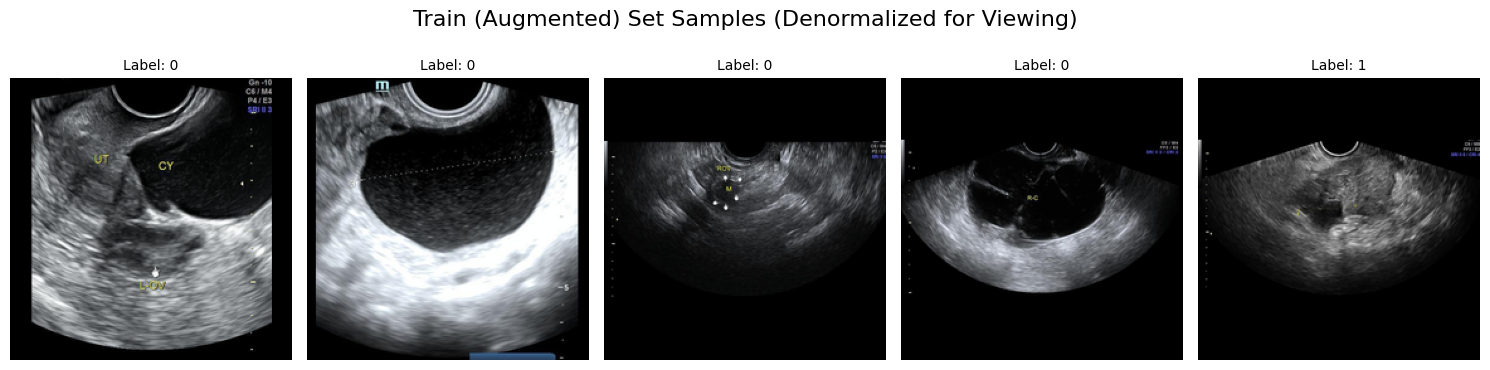

Total Validation Samples: 469
Validation Set Malignant (1) Count: 15


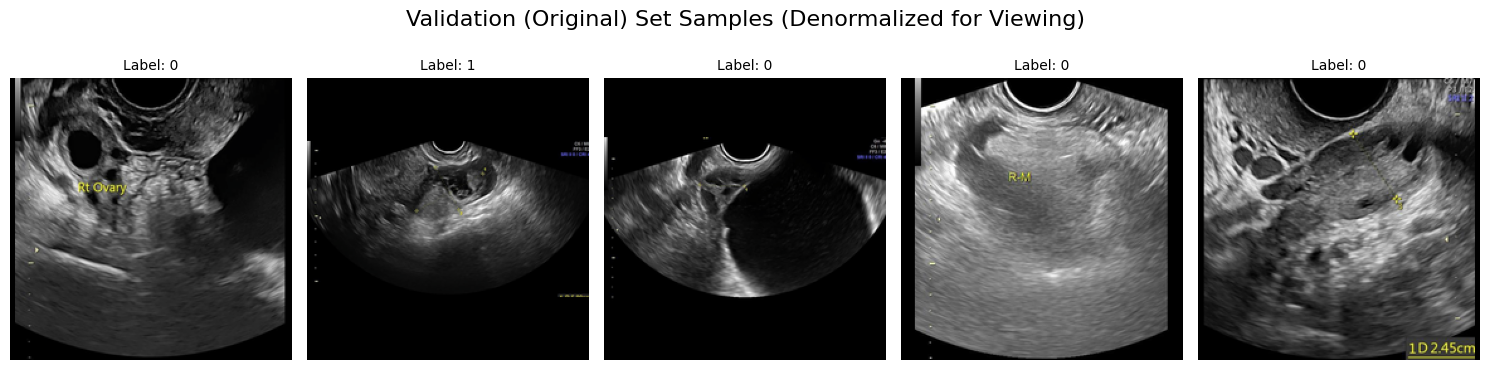

In [ ]:
X_train, y_train, X_val, y_val = create_split_dataset(OUTPUT_PATH)

print("[Final Data Summary]")
if X_train is not None and len(X_train) > 0:
    malignant_count = np.sum(y_train)
    benign_count = len(y_train) - malignant_count
    print(f"Total Train Samples: {len(X_train)}")
    print(f"Train Set Malignant (1) Count: {malignant_count} (Augmented)")
    print(f"Train Set Benign (0) Count: {benign_count}")
    print(f"Train Imbalance Ratio (M/B): {malignant_count / benign_count:.2f}")
    visualize_samples(X_train, y_train, 'Train (Augmented)', num_samples=5)

if X_val is not None and len(X_val) > 0:
    print(f"Total Validation Samples: {len(X_val)}")
    print(f"Validation Set Malignant (1) Count: {np.sum(y_val)}")
    visualize_samples(X_val, y_val, 'Validation (Original)', num_samples=5)